In [8]:
from pathlib import Path
import re
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from lumicks import pylake
from lumicks.pylake.file import FdCurve
import seaborn as sns
from skimage.measure import label
from scipy.signal import find_peaks
from dataclasses import dataclass
import pandas as pd

In [9]:
@dataclass
class ForcePeak:
    distance: float
    force: float
    index: int


@dataclass
class Oscillation:
    increasing_force: npt.NDArray[np.float64]
    increasing_distance: npt.NDArray[np.float64]
    decreasing_force: npt.NDArray[np.float64]
    decreasing_distance: npt.NDArray[np.float64]
    force_peaks: list[ForcePeak] | None = None
    num_peaks: int | None = None

    def plot(self, title: str = "", plot_peaks=True):
        plt.figure(figsize=(10, 5))
        plt.plot(self.increasing_distance, self.increasing_force, label="Increasing Segment")
        plt.plot(self.decreasing_distance, self.decreasing_force, label="Decreasing Segment")
        if plot_peaks:
            if self.force_peaks:
                # plot a vertical line at each peak
                for peak in self.force_peaks:
                    plt.axvline(
                        x=peak.distance,
                        color="grey",
                        linestyle="--",
                        label="Detected Peak" if peak == self.force_peaks[0] else "",
                    )
        plt.xlabel("Distance (nm)")
        plt.ylabel("Force (pN)")
        plt.title("Force-Distance Curve")
        plt.legend()
        plt.title(title)
        plt.show()

    def find_peaks(
        self,
        peak_height: tuple[float, float] | None = None,
        peak_prominence: float | None = None,
        verbose: bool | None = None,
        plotting: bool | None = None,
        oscillation_index: int | None = None,
        curve_id: str | None = None,
    ):
        # find the peaks just in this oscillation
        # allow overrides but keep the original defaults in the sub function
        kwargs = {k: v for k, v in locals().items() if k != "self" and v is not None}
        return find_peaks_individual_oscillation(oscillation=self, **kwargs)


@dataclass
class ReducedFDCurve:
    filename: str
    curve_id: int
    all_forces: npt.NDArray[np.float64]
    all_distances: npt.NDArray[np.float64]
    oscillations: list[Oscillation]
    include_in_processing: bool = True


class ReducedMarker:
    def __init__(self, file_path: Path, verbose: bool = False, plotting: bool = False):
        self.file_path = file_path
        self.file_name = file_path.name
        self.file = pylake.File(self.file_path)
        self.metadata = self.get_file_metadata(self.file_name)
        self.telereps = self.metadata["telereps"]
        self.protein_name = self.metadata["protein_name"]
        self.fd_curves = self.load_curves(
            filename=self.file_name, fdcurves=self.file.fdcurves, verbose=verbose, plotting=plotting
        )
        self.include_in_processing = True

    @staticmethod
    def get_file_metadata(filename: str) -> dict[str, str]:
        """
        Obtain file metadata from the filename.

        Parameters
        ----------
        filename : str
            The name of the file to extract the metadata from.

        Returns
        -------
        dict[str, str]
            A dictionary containing the metadata extracted from the filename.
        """
        metadata = {}
        # grab tel_reps
        tel_reps = re.search(r"Tel(\d+)", filename)
        if tel_reps:
            tel_reps = int(tel_reps.group(1))
        else:
            raise ValueError(f"Could not find telereps regex: Tel(\\d+) in file name {filename}")
        metadata["telereps"] = tel_reps
        # grab protein name, assumed to be before the string "Marker X"
        protein_name = re.search(r" (\w+)(?= Marker \d+)", filename)
        if protein_name:
            protein_name = protein_name.group(1)
        else:
            raise ValueError(f"Could not find protein name in file name {filename}")
        metadata["protein_name"] = protein_name

        return metadata

    @staticmethod
    def load_curves(
        filename: str, fdcurves: dict[str, FdCurve], verbose: bool = False, plotting: bool = False
    ) -> dict[str, ReducedFDCurve]:
        """
        Load the force-distance curves from the file.

        Parameters
        ----------
        fdcurves : dict[str, pylake.FdCurve]
            A dictionary of force-distance curves.
        verbose : bool, optional
            If True, print additional information about the curves being loaded. Default is False.
        plotting : bool, optional
            If True, plot the intermediate plots. Default is False.

        Returns
        -------
        dict[str, ReducedFDCurve]
            A dictionary of reduced force-distance curves, where the keys are the curve IDs and the values are
            instances of ReducedFDCurve containing the force and distance data, as well as the oscillations found in
            the curves.
        """
        fd_curves = {}
        for curve_id, curve_data in fdcurves.items():
            if verbose:
                print(f"Loading curve {curve_id} with {len(curve_data.d.data)} data points.")
            force_data = curve_data.f.data
            distance_data = curve_data.d.data

            if plotting:
                plt.plot(distance_data, force_data, label=f"Curve {curve_id}")
                plt.title(f"Force-Distance Curve {curve_id}")
                plt.ylabel("Force (pN)")
                plt.xlabel("Distance (um)")
                plt.legend()
                plt.show()

            # determine the starting distance to be the first peak in frequency of the distance data
            bin_size_um = 0.1
            bin_edges = np.arange(np.min(distance_data), np.max(distance_data) + bin_size_um, bin_size_um)
            hist, _ = np.histogram(distance_data, bins=bin_edges)

            if False:
                # plot the histogram
                plt.hist(distance_data, bins=bin_edges, alpha=0.5, label=f"Curve {curve_id}")
                plt.title(f"Distance Histogram {curve_id}")
                plt.ylabel("Counts")
                plt.xlabel("Distance (um)")
                plt.legend()
                plt.show()

            # find the largest peak in the histogram
            peak_index = np.argmax(hist)
            # get the midpoint of the bin
            base_distance = (bin_edges[peak_index] + bin_edges[peak_index + 1]) / 2
            if verbose:
                print(f"Base distance: {base_distance} um")

            # check that the peak is strong, as in that the peak bin contains a lot more counts than the other bins
            # critera: peak should be at least 2x the next highest bin
            next_highest_bin = np.partition(hist, -2)[-2]
            peak_strength = hist[peak_index] / next_highest_bin if next_highest_bin > 0 else 0
            if verbose:
                print(f"Peak strength: {peak_strength:.2f} (peak is strength * next highest bin)")
            peak_strength_threshold = 2.0
            if peak_strength < peak_strength_threshold:
                print(
                    f"Peak at {base_distance} um is not strong enough (<{peak_strength_threshold})."
                    f" skipping curve {curve_id}"
                )
                continue

            flat_distance_um = base_distance
            flat_distance_tolerance_um = 0.1

            flat_regions_bool = np.abs(distance_data - flat_distance_um) < flat_distance_tolerance_um
            flat_regions: list[tuple[int, int]] = []
            current_flat_region_start = None
            for index, is_flat in enumerate(flat_regions_bool):
                if is_flat and current_flat_region_start is None:
                    current_flat_region_start = index
                elif not is_flat and current_flat_region_start is not None:
                    flat_regions.append((current_flat_region_start, index - 1))
                    current_flat_region_start = None
            if current_flat_region_start is not None:
                flat_regions.append((current_flat_region_start, len(flat_regions_bool) - 1))

            if verbose:
                print(f"Flat regions: {flat_regions}")

            # eliminate non-flat regions at the start and end of the curve
            if flat_regions:
                if flat_regions[0][0] > 0:
                    # cut the array to start at the first flat region
                    distance_data_trimmed = distance_data[flat_regions[0][0] :]
                    force_data_trimmed = force_data[flat_regions[0][0] :]
                    flat_regions_bool_trimmed = flat_regions_bool[flat_regions[0][0] :]
                else:
                    distance_data_trimmed = distance_data
                    force_data_trimmed = force_data
                    flat_regions_bool_trimmed = flat_regions_bool
                if flat_regions[-1][1] < len(distance_data_trimmed) - 1:
                    # cut the array to end at the last flat region
                    distance_data_trimmed = distance_data_trimmed[: flat_regions[-1][1] + 1]
                    force_data_trimmed = force_data_trimmed[: flat_regions[-1][1] + 1]
                    flat_regions_bool_trimmed = flat_regions_bool_trimmed[: flat_regions[-1][1] + 1]
            else:
                distance_data_trimmed = distance_data
                force_data_trimmed = force_data
                flat_regions_bool_trimmed = flat_regions_bool

            if plotting:
                plt.plot(distance_data, label="Distance Data")
                plt.plot(distance_data_trimmed, label="Trimmed Distance Data", linestyle="--")
                plt.title(f"Distance data retrieved via file.fdcurves[{curve_id}].d.data")
                plt.xlabel("Index")
                plt.ylabel("Distance (um)")
                plt.legend()
                plt.show()

            # get the non-flat regions
            non_flat_regions_bool_trimmed = ~flat_regions_bool_trimmed
            # label the non-flat regions
            labelled_non_flat_regions = label(non_flat_regions_bool_trimmed)
            # for each non-flat region, determine the maximum distance value and set the indexes to the left of it
            # as the increasing segment and indexes to the right as the decreasing segment
            oscillations: list[Oscillation] = []
            for label_index in range(1, labelled_non_flat_regions.max() + 1):
                # get the indexes of the current non-flat region
                non_flat_region_indexes = np.argwhere(labelled_non_flat_regions == label_index)
                non_flat_region_start = non_flat_region_indexes[0][0]
                non_flat_region_end = non_flat_region_indexes[-1][0]
                non_flat_region_distances = distance_data_trimmed[non_flat_region_start : non_flat_region_end + 1]
                non_flat_region_local_maximum_distance_index = np.argmax(non_flat_region_distances)
                non_flat_region_global_maximum_distance_index = (
                    non_flat_region_start + non_flat_region_local_maximum_distance_index
                )
                # set the increasing segment to the left of the maximum distance index, with the second index being
                # exclusive
                increasing_segment_start = non_flat_region_start
                # keep the largest distance value in the increasing segment
                increasing_segment_end = non_flat_region_global_maximum_distance_index + 1
                # set the decreasing segment to the right of the maximum distance index, with the second index
                # being exclusive
                decreasing_segment_start = non_flat_region_global_maximum_distance_index + 1
                decreasing_segment_end = non_flat_region_end + 1
                # get the force data for the increasing and decreasing segments
                increasing_force = force_data_trimmed[increasing_segment_start:increasing_segment_end]
                increasing_distance = distance_data_trimmed[increasing_segment_start:increasing_segment_end]
                decreasing_force = force_data_trimmed[decreasing_segment_start:decreasing_segment_end]
                decreasing_distance = distance_data_trimmed[decreasing_segment_start:decreasing_segment_end]

                # create an Oscillation object
                oscillation = Oscillation(
                    increasing_force=increasing_force,
                    increasing_distance=increasing_distance,
                    decreasing_force=decreasing_force,
                    decreasing_distance=decreasing_distance,
                )
                oscillations.append(oscillation)

            # Check the oscillations by fitting an ewlc model to the return curve

            for oscillation_index, oscillation in enumerate(oscillations):
                increasing_force = oscillation.increasing_force
                increasing_distance = oscillation.increasing_distance
                decreasing_force = oscillation.decreasing_force
                decreasing_distance = oscillation.decreasing_distance

                if plotting:
                    xs = np.arange(len(increasing_distance) + len(decreasing_distance))
                    # plot the distance data
                    plt.plot(xs[: len(increasing_distance)], increasing_distance, label="increasing")
                    plt.plot(xs[len(increasing_distance) :], decreasing_distance, label="decreasing")
                    plt.title(f"Oscillation {oscillation_index} distance segments for curve {curve_id}")
                    plt.xlabel("Index")
                    plt.ylabel("Distance (um)")
                    plt.legend()
                    plt.show()
                    # plot the force data
                    plt.plot(xs[: len(increasing_force)], increasing_force, label="increasing")
                    plt.plot(xs[len(increasing_force) :], decreasing_force, label="decreasing")
                    plt.title(f"Oscillation {oscillation_index} force segments for curve {curve_id}")
                    plt.xlabel("Index")
                    plt.ylabel("Force (pN)")
                    plt.legend()
                    plt.show()

                # fit a ewlc model to the decreasing segment
                model = pylake.ewlc_odijk_force(name="ewlc_return_fit") + pylake.force_offset(name="ewlc_return_fit")
                fit = pylake.FdFit(model)
                fit.add_data(name="return", f=decreasing_force, d=decreasing_distance)
                fit["ewlc_return_fit/Lp"].value = 50
                fit["ewlc_return_fit/Lp"].lower_bound = 39
                fit["ewlc_return_fit/Lp"].upper_bound = 80
                fit["ewlc_return_fit/Lc"].value = 27
                fit["ewlc_return_fit/f_offset"].lower_bound = 0
                fit["ewlc_return_fit/f_offset"].upper_bound = 1

                fit.fit()
                # note that the error for some reason is the same value repeated for each point. taking the mean
                # just in case this changes.
                error = np.mean(fit.sigma)

                if plotting:
                    fit.plot()
                    plt.title(
                        f"Fit for decreasing segment of oscillation {oscillation_index} for "
                        f"curve {curve_id} after fitting. Error: {error:.2f} pN"
                    )
                    plt.xlabel("Distance (um)")
                    plt.ylabel("Force (pN)")
                    plt.legend()
                    plt.show()

            if verbose:
                print(f"Found {len(oscillations)} oscillations in curve {curve_id}.")
            # create a FDCurve object
            fd_curve = ReducedFDCurve(
                filename=filename,
                curve_id=curve_id,
                all_forces=force_data_trimmed,
                all_distances=distance_data_trimmed,
                oscillations=oscillations,
            )
            fd_curves[curve_id] = fd_curve

            if verbose:
                print(f"Loaded curve {curve_id} from {filename}.")

        return fd_curves

    def find_peaks_marker(
        self,
        peak_height: tuple[float, float] = (0.5, 30),
        prominence=0.8,
        verbose: bool = False,
        plotting: bool = False,
    ):
        """Find peaks in the oscillations"""
        # iterate over the oscillations and find peaks, adding them to the oscillation objects
        for curve_id, fd_curve in self.fd_curves.items():
            if verbose:
                print(f"Finding peaks in curve {curve_id} with {len(fd_curve.oscillations)} oscillations.")
            for oscillation_index, oscillation in enumerate(fd_curve.oscillations):
                force_peaks = find_peaks_individual_oscillation(
                    oscillation=oscillation,
                    peak_height=peak_height,
                    peak_prominence=prominence,
                    verbose=verbose,
                    plotting=plotting,
                    oscillation_index=oscillation_index,
                    curve_id=curve_id,
                )

                if len(force_peaks) == 0:
                    if verbose:
                        print(f"No peaks found in oscillation {oscillation_index} for curve {curve_id}.")

                if verbose:
                    # print force peak distances formatted to .2f
                    force_peak_distances = [f"{peak.distance:.2f}" for peak in force_peaks]
                    print(
                        f"Found {len(force_peaks)} peaks in oscillation {oscillation_index} for curve {curve_id}: "
                        f"{', '.join(force_peak_distances)}"
                    )
                # add the force peaks to the oscillation object
                oscillation.force_peaks = force_peaks


@staticmethod
def find_peaks_individual_oscillation(
    oscillation: Oscillation,
    peak_height: tuple[float, float] = (0.5, 30),
    peak_prominence=0.8,
    verbose: bool = False,
    plotting: bool = False,
    oscillation_index: int | None = None,
    curve_id: str | None = None,
) -> list[ForcePeak]:
    """
    Find peaks in an individual oscillation's increasing distance-force curve.

    Note that I think we are making a huge assumption that the distance changes at a constant rate, since we don't
    fit the peaks on the 2d data, but rather only on the force data, ignoring the distance components.

    Parameters
    ----------
    oscillation : Oscillation
        The oscillation object containing force and distance data.
    peak_height : tuple[float, float], optional
        The minimum and maximum height of the peaks to be detected.
    peak_prominence : float, optional
        The prominence of the peaks to be detected.
    verbose : bool, optional
        If True, print additional information about the peaks found.
    plotting : bool, optional
        If True, plot the increasing segment with the detected peaks.

    Returns
    -------
    list[ForcePeak]
        A list of ForcePeak objects.
    """
    # find peaks in the increasing force-distance segment
    increasing_force = oscillation.increasing_force
    increasing_distance = oscillation.increasing_distance
    peak_indexes, _ = find_peaks(increasing_force, height=peak_height, prominence=peak_prominence)
    if len(peak_indexes) == 0:
        return np.array([])
    if plotting:
        # plot the increasing segment with the peaks
        plt.plot(increasing_distance, increasing_force, label="increasing")
        # vlines for the peaks
        plt.vlines(
            increasing_distance[peak_indexes],
            ymin=np.min(increasing_force),
            ymax=np.max(increasing_force),
            color="grey",
            label="peaks",
            linestyle="--",
        )
        plt.title(f"Peaks in increasing segment of oscillation {oscillation_index} for curve {curve_id}")
        plt.xlabel("Distance (um)")
        plt.ylabel("Force (pN)")
        plt.legend()
        plt.show()
    force_peaks = []
    for peak_index in peak_indexes:
        force_peak = ForcePeak(
            distance=increasing_distance[peak_index],
            force=increasing_force[peak_index],
            index=peak_index,
        )
        force_peaks.append(force_peak)
    return force_peaks

In [10]:
def rupture_force_stats(
    markers: dict[str, ReducedMarker],
    verbose: bool = False,
    plotting: bool = False,
) -> pd.DataFrame:
    """
    Calculate rupture force stats for a list of markers.
    """
    all_peak_stats = []
    for marker_filename, marker in markers.items():
        if verbose:
            print(f"Calculating rupture force stats for marker {marker.file_name}")
        if not marker.include_in_processing:
            print(f"Ignoring non-included marker: {marker.file_name}.")
            continue
        for curve_id, fd_curve in marker.fd_curves.items():
            if verbose:
                print(f"  Curve ID: {curve_id}")
            if not fd_curve.include_in_processing:
                print(f"  Ignoring non-included curve: {curve_id}.")
                continue
            for oscillation_index, oscillation in enumerate(fd_curve.oscillations):
                if oscillation.force_peaks is None:
                    if verbose:
                        print(f"    Oscillation {oscillation_index}: Hasn't been processed for peaks yet.")
                    continue
                # add the force peaks to the list
                for force_peak in oscillation.force_peaks:
                    all_peak_stats.append(
                        {
                            "marker": marker_filename,
                            "curve_id": curve_id,
                            "oscillation_index": oscillation_index,
                            "distance": force_peak.distance,
                            "force": force_peak.force,
                            "tel_reps": marker.telereps,
                            "protein_name": marker.protein_name,
                        }
                    )
    if verbose:
        print(f"Found {len(all_peak_stats)} force peaks in total across all markers.")
    # create a DataFrame from the list of dictionaries
    df = pd.DataFrame(all_peak_stats)
    if plotting:
        # plot the force peaks by protein name
        sns.scatterplot(data=df, x="distance", y="force", hue="protein_name")
        plt.title("Force Peaks")
        plt.xlabel("Distance (um)")
        plt.ylabel("Force (pN)")
        plt.legend(title="protein")
        plt.show()
        # plot the force peaks by tel reps
        sns.scatterplot(data=df, x="distance", y="force", hue="tel_reps")
        plt.title("Force Peaks")
        plt.xlabel("Distance (um)")
        plt.ylabel("Force (pN)")
        plt.legend(title="tel reps")
        plt.show()
    return df

Loading marker from file: /Users/sylvi/optical_data/loading_markers/data/20250611-151042  Tel5 1nM Trf2dTRFH Marker 1.h5
Peak at 39.972418621918436 um is not strong enough (<2.0). skipping curve 2
Loading marker from file: /Users/sylvi/optical_data/loading_markers/data/20250611-134556 Tel5 1nM Trf2dTRFH Marker 3.h5
Loading marker from file: /Users/sylvi/optical_data/loading_markers/data/20250611-124102 Tel5 1nM Trf2dTRFH Marker 1.h5
Loading marker from file: /Users/sylvi/optical_data/loading_markers/data/20250611-132105 Tel5 1nM Trf2dTRFH Marker 2.h5
Peak at 28.24755549632156 um is not strong enough (<2.0). skipping curve 16
----------------------------------------------------------------------------------------------------
Marker: 20250611-151042  Tel5 1nM Trf2dTRFH Marker 1.h5
  Curve ID: 1
    Oscillation 0: 0 peaks found at 
  Curve ID: 3
    Oscillation 0: 6 peaks found at 23.16 um, 28.46 um, 31.01 um, 33.20 um, 35.00 um, 36.73 um
    Oscillation 1: 6 peaks found at 22.92 um, 29.0

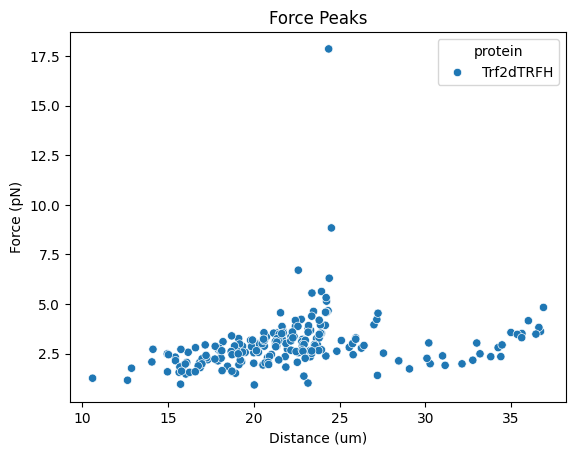

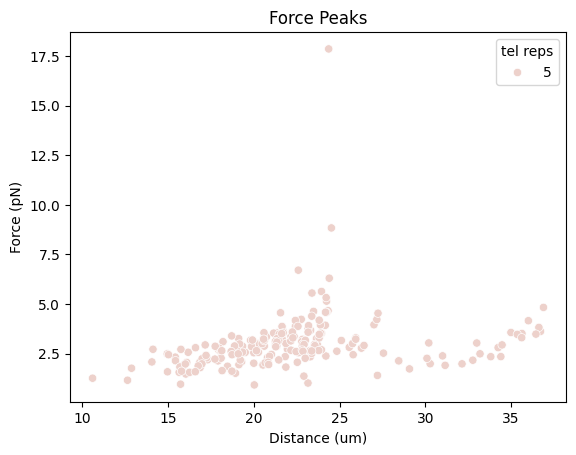

In [11]:
data_dirs = [Path("/Users/sylvi/optical_data/loading_markers/data")]
for data_dir in data_dirs:
    assert data_dir.exists(), f"Data directory {data_dir} does not exist."
output_folder = Path("/Users/sylvi/optical_data/loading_markers/processed/")
markers: dict[str, ReducedMarker] = {}
for data_dir in data_dirs:
    for file in data_dir.glob("*.h5"):
        if file.is_file() and "Marker" in file.name:
            print(f"Loading marker from file: {file}")
            marker = ReducedMarker(file_path=file, verbose=False, plotting=False)
            markers[file.name] = marker

            # find peaks
            marker.find_peaks_marker(
                peak_height=(0.5, 30),
                prominence=0.8,
                verbose=False,
                plotting=False,
            )

print("-" * 100)

# print all peaks found
for marker_name, marker in markers.items():
    print(f"Marker: {marker_name}")
    for curve_id, fd_curve in marker.fd_curves.items():
        print(f"  Curve ID: {curve_id}")
        for oscillation_index, oscillation in enumerate(fd_curve.oscillations):
            print(
                f"    Oscillation {oscillation_index}: "
                f"{len(oscillation.force_peaks)} peaks found at "
                f"{', '.join([f'{peak.distance:.2f} um' for peak in oscillation.force_peaks])}"
            )

# Calculate and print rupture force stats
print("-" * 100)
rupture_force_df = rupture_force_stats(
    markers=markers,
    verbose=False,
    plotting=True,
)

markers: dict_keys(['20250611-151042  Tel5 1nM Trf2dTRFH Marker 1.h5', '20250611-134556 Tel5 1nM Trf2dTRFH Marker 3.h5', '20250611-124102 Tel5 1nM Trf2dTRFH Marker 1.h5', '20250611-132105 Tel5 1nM Trf2dTRFH Marker 2.h5'])
fdcurves: dict_keys(['1', '3', '4'])
oscillations list: [0 1 2]


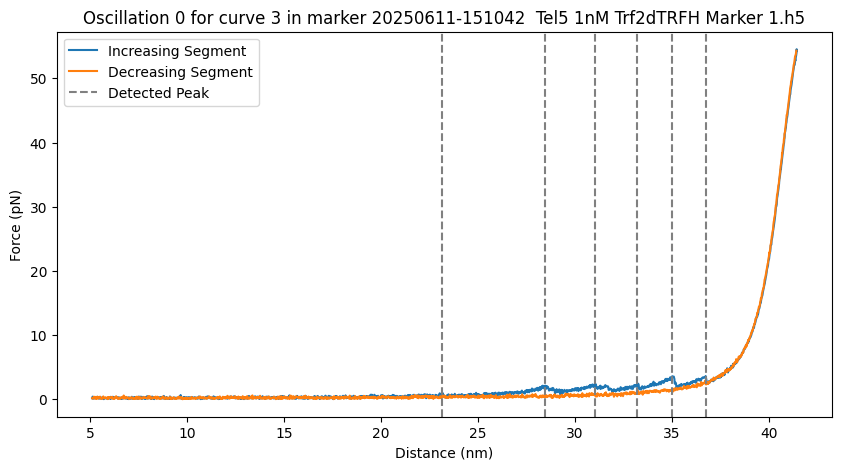

pre-fit params:
No parameters


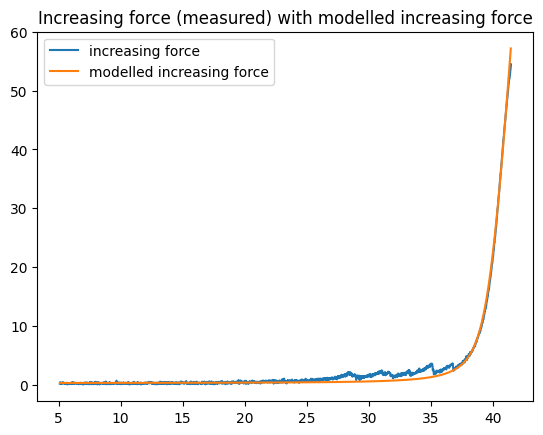

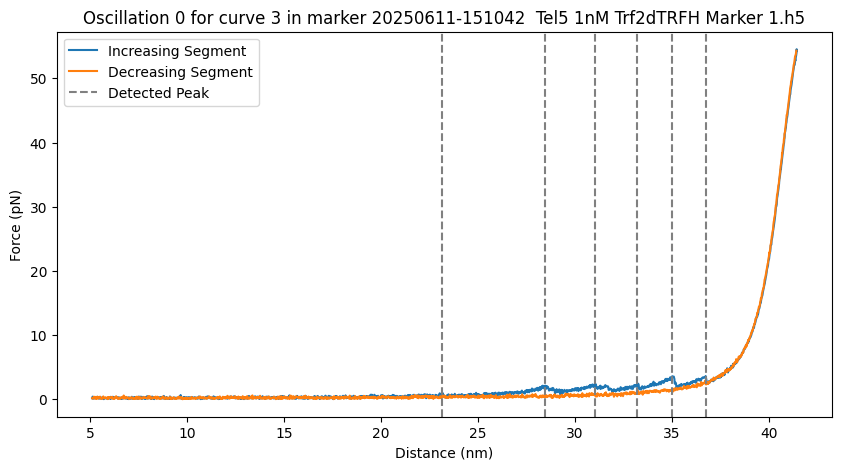

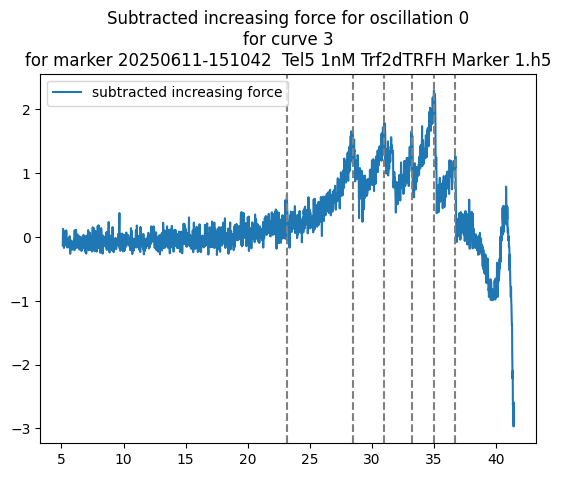

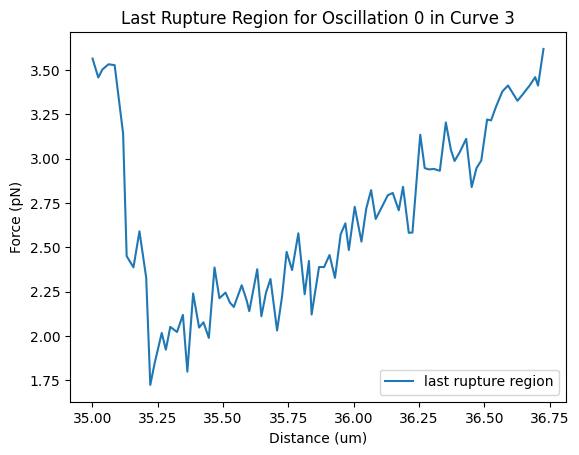

In [17]:
# Just analyse one curve
print(f"markers: {markers.keys()}")
marker_to_analyse = "20250611-151042  Tel5 1nM Trf2dTRFH Marker 1.h5"
marker = markers[marker_to_analyse]
marker_fdcurves = marker.fd_curves
print(f"fdcurves: {marker_fdcurves.keys()}")
curve_id = "3"
marker_fdcurve = marker_fdcurves[curve_id]
fdcurve_oscillations = marker_fdcurve.oscillations
print(f"oscillations list: {np.arange(len(fdcurve_oscillations))}")
oscillation_index = 0
oscillation = fdcurve_oscillations[oscillation_index]
oscillation.plot(title=f"Oscillation {oscillation_index} for curve {curve_id} in marker {marker_to_analyse}")

# fit the return curve
model = pylake.ewlc_odijk_force(name="ewlc_return_fit") + pylake.force_offset(name="ewlc_return_fit")
fit = pylake.FdFit(model)
print(f"pre-fit params:")
print(fit.params)
fit.add_data(name="return", f=oscillation.decreasing_force, d=oscillation.decreasing_distance)
fit["ewlc_return_fit/Lp"].value = 50
fit["ewlc_return_fit/Lp"].lower_bound = 39
fit["ewlc_return_fit/Lp"].upper_bound = 80
fit["ewlc_return_fit/Lc"].value = 27
fit["ewlc_return_fit/f_offset"].lower_bound = 0
fit["ewlc_return_fit/f_offset"].upper_bound = 1

fit.fit()
# note that the error for some reason is the same value repeated for each point. taking the mean
# just in case this changes.
error = np.mean(fit.sigma)

# subtract the increasing curve by the fitted model decreasing curve, assuming the two are similar
modelled_increasing_force = model(independent=oscillation.increasing_distance, params=fit.params)
plt.plot(oscillation.increasing_distance, oscillation.increasing_force, label="increasing force")
plt.plot(oscillation.increasing_distance, modelled_increasing_force, label="modelled increasing force")
plt.legend()
plt.title("Increasing force (measured) with modelled increasing force")
plt.show()

# find the peaks in the oscillation
oscillation.plot(title=f"Oscillation {oscillation_index} for curve {curve_id} in marker {marker_to_analyse}")

subtracted_increasing_force = oscillation.increasing_force - modelled_increasing_force
plt.plot(oscillation.increasing_distance, subtracted_increasing_force, label="subtracted increasing force")
plt.legend()
for force_peak in oscillation.force_peaks:
    plt.axvline(
        x=force_peak.distance,
        color="grey",
        linestyle="--",
        label="Detected Peak" if force_peak == oscillation.force_peaks[0] else "",
    )
plt.title(
    f"Subtracted increasing force for oscillation {oscillation_index}\nfor curve {curve_id}\nfor marker {marker_to_analyse}"
)
plt.show()

# Grab the rupture region preceding the main curve, ie the data between the penultimate and last force peak
penultimate_peak_position = oscillation.force_peaks[-2].index
last_peak_position = oscillation.force_peaks[-1].index
last_rupture_region_force = oscillation.increasing_force[penultimate_peak_position:last_peak_position + 1]
last_rupture_region_distance = oscillation.increasing_distance[penultimate_peak_position:last_peak_position + 1]

# plot the last rupture region
plt.plot(last_rupture_region_distance, last_rupture_region_force, label="last rupture region")
plt.title(f"Last Rupture Region for Oscillation {oscillation_index} in Curve {curve_id}")
plt.xlabel("Distance (um)")
plt.ylabel("Force (pN)")
plt.legend()
plt.show()